# Hierarchical Clustering
**Written by Christian Alis**

Representative-based clustering methods are flat clustering methods. You tell them to cluster data points into $k$ clusters and they will assign a point into exactly one cluster. Hierarchical clustering methods, on the other hand, assign points to a branch of a tree. Instead of having a priori value of $k$, it can be set after analysis, depending on where in the tree (hierarchy) you want to be.

There are two main types of hierarchical clustering:
* **Agglomerative clustering**: bottom-up approach where smaller clusters are merged with nearby clusters
* **Divisive clustering**: top-down approach where clusters are successively partitioned into smaller clusters

In this notebook, we will study four agglomerative clustering methods.

# Sample datasets

We will make use of the same datasets we investigated last time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.testing.compare import compare_images
from sklearn.datasets import load_wine, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from IPython.display import HTML

In [2]:
data_wine = load_wine()
standard_scaler = StandardScaler()
X_wine = standard_scaler.fit_transform(data_wine['data'])
target_wine = data_wine['target']

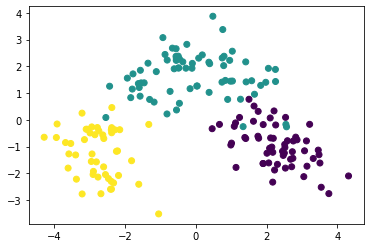

In [3]:
X_wine_new = PCA(n_components=2, random_state=1337).fit_transform(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=target_wine);

In [4]:
data_newsgroups = fetch_20newsgroups(
    subset='train', 
    categories=['comp.graphics', 'rec.autos'],
    shuffle=False, 
    remove=['headers', 'footers', 'quotes'])
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z-]+', 
                                   stop_words='english',
                                   min_df=5)
bow_ng = tfidf_vectorizer.fit_transform(data_newsgroups['data'])
nonzeros = bow_ng.sum(axis=1).nonzero()[0]
bow_ng = bow_ng[nonzeros]
target_ng = data_newsgroups['target'][nonzeros]

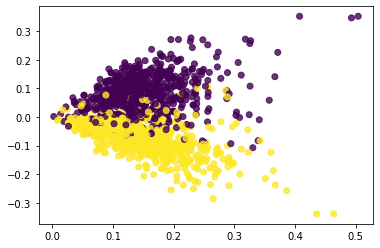

In [5]:
X_ng_new = (TruncatedSVD(n_components=2, random_state=1337)
                .fit_transform(bow_ng))
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=target_ng, alpha=0.8);

# Agglomerative clustering

This is the generic agglomerative clustering algorithm:

**Algorithm** *AgglomerativeClustering*(Database: $D$)  
**begin**  
$\quad$Initialize $n \times n$ distance metric $M$ using $D$;  
$\quad$Assign each $i \in D$ to its own cluster;  
$\quad$**repeat**  
$\quad$$\quad$Pick closest pair of clusters $i$ and $j$ using $M$;  
$\quad$$\quad$Merge clusters $i$ and $j$;  
$\quad$$\quad$Delete rows/columns $i$ and $j$ from $M$ and create a new row and column for newly merged cluster;  
$\quad$$\quad$Update the entries of new row and column of $M$;  
$\quad$**until** termination criterion;  
$\quad$**return** clustering;  
**end**

Different agglomerative clustering methods differ on how they compute the distance between clusters. The different cluster distance measures are:

* **Change in SSE**: increase in the sum-of-squared errors when the clusters are merged
* **Single linkage**: smallest distance between a point from one cluster to any point in the other cluster
* **Complete linkage**: farthest distance between a point from one cluster to any point in the other cluster
* **Group-average linkage**: average intercluster distance
* **Centroid**: distance between cluster centroids
* **Change in cluster variance**: increase in the objective function (cluster variance) when the clusters are merged

We will only discuss the first four measures in this notebook.

## Ward's method

The first agglomerative method that we will study is Ward's method. This method defines the distance between two clusters, $A$ and $B$, as the amount the sum of squares will increase when we merge them:

$$
\Delta(A, B) = \sum_{i \in A \bigcup B} \|x_i - m_{A \bigcup B}\|^2 - \sum_{i \in A} \|x_i - m_A\|^2 - \sum_{i \in B} \|x_i - m_B\|^2
$$

where $m_j$ is the center of cluster $j$, and $n_j$ is the number of points in it. $\Delta$ is the merging cost of combining the clusters $A$ and $B$. Starting from individual points as a cluster, the method merges them while trying to minimize the growth of $\Delta$. Given two pairs of clusters whose centers are equally far apart, Ward’s method will prefer to merge the smaller ones. Note that $\Delta$ always increases when we merge clusters.

We apply it to the wines dataset.

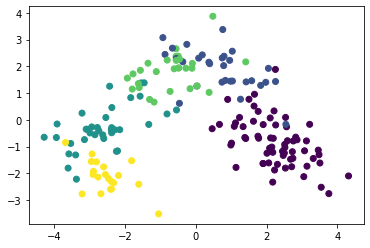

In [6]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5)
y_predict_wine = agg.fit_predict(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

A benefit of hierarchical clustering is that the number of clusters can be changed after performing the clustering. The number of clusters is usually selected based on a visualization (dendrogram) of the clustering hierarchy. Unfortunately, there's no function that we can use to plot the dendrogram of the `AgglomerativeClustering` class. Thus, we will use `scipy.cluster.hierarchy` functions for clustering and plotting the dendrogram.

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_wine, method='ward', optimal_ordering=True)

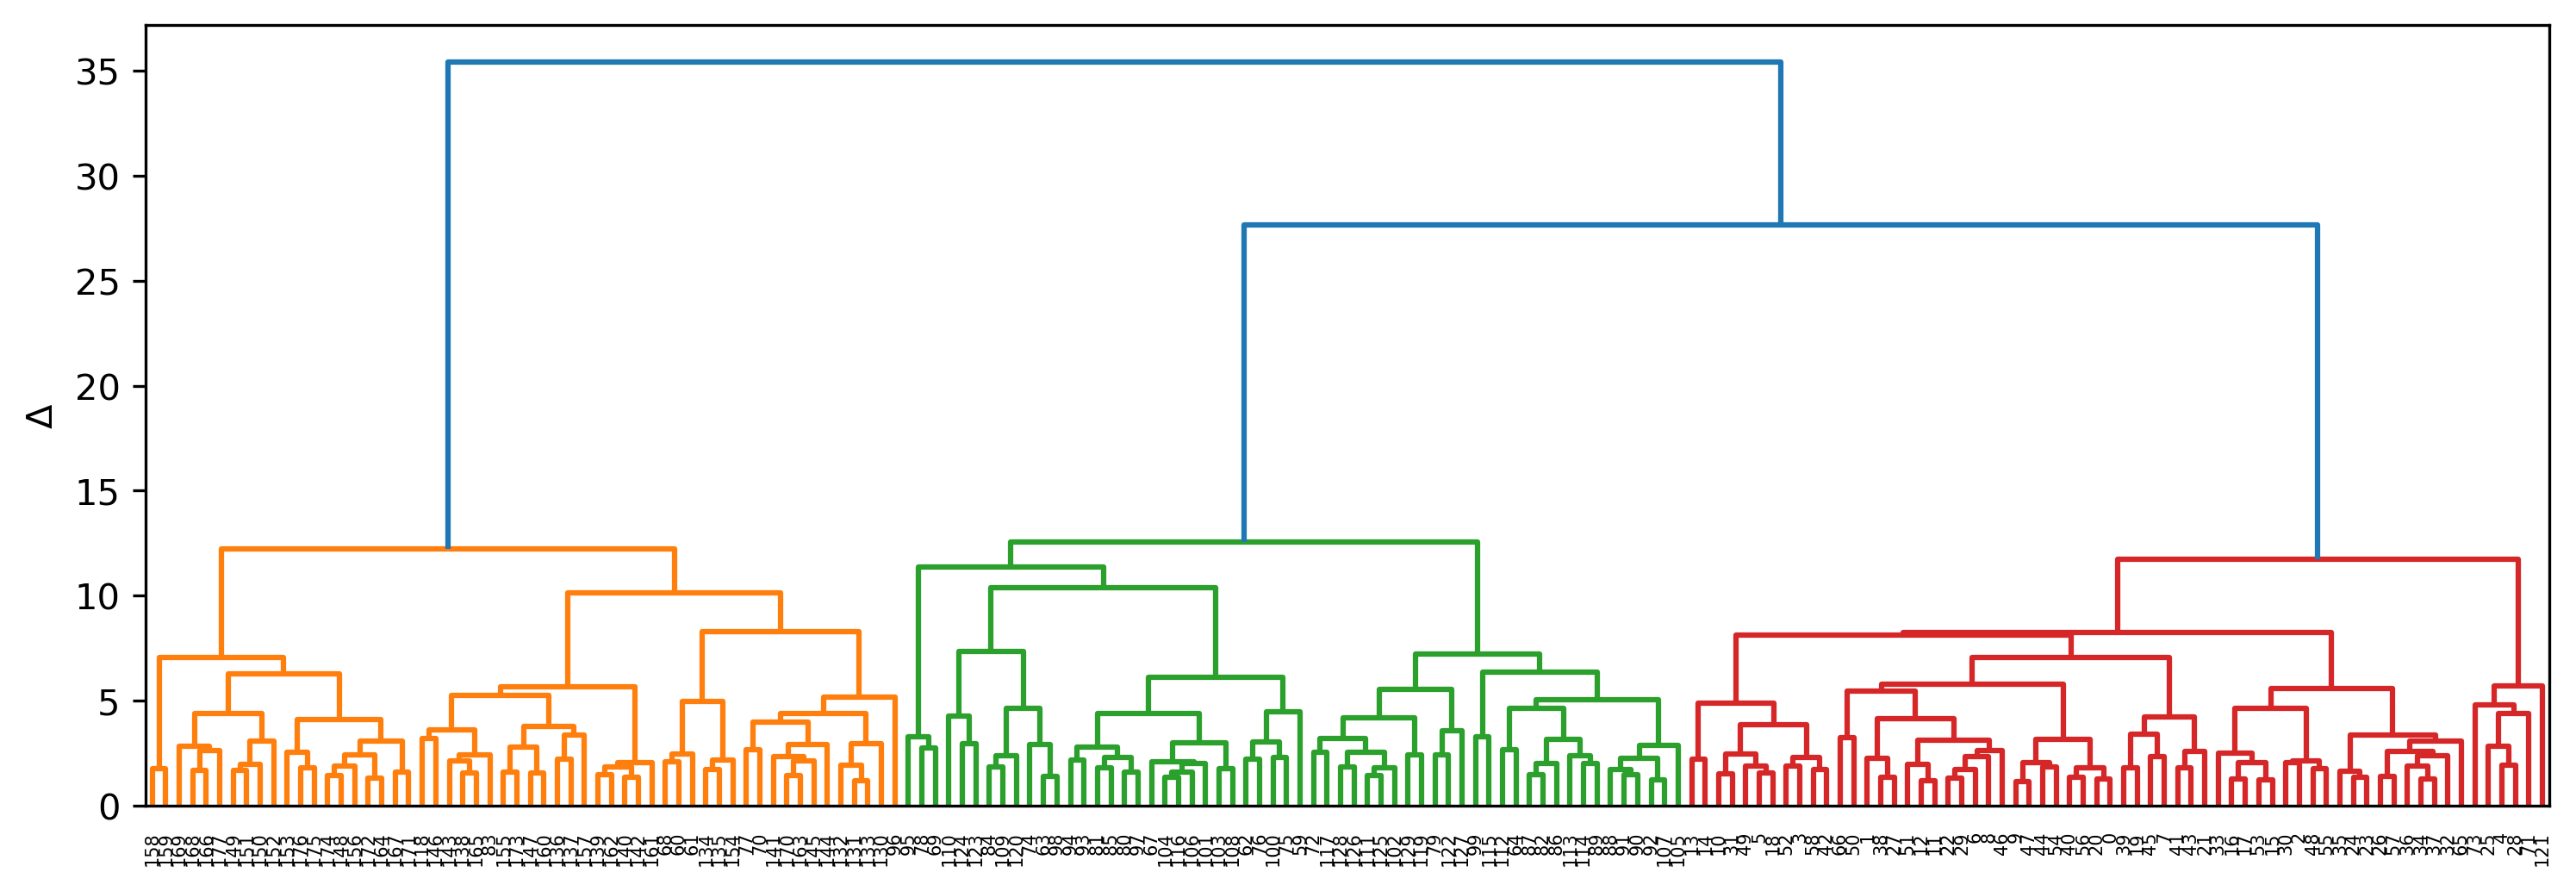

In [8]:
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$\Delta$');

The dendrogram is too crowded so let's try to clean it up a bit.

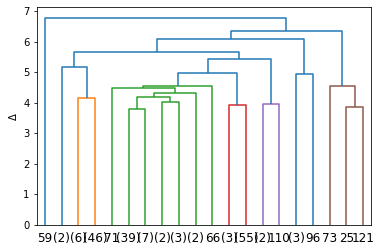

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_wine, method='average', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, truncate_mode='lastp',p=20, ax=ax)
ax.set_ylabel(r'$\Delta$');

**Exercise 14**

Create a function `plot1` that accepts the output of linkage and replicates the plot below.

![](plot1.png)

In [10]:
def plot1(Z):
    """Plot the dendrogram of the linkage matrix.
    
    PARAMETERS
    ----------
    Z : array of the linkage matrix
    
    RETURNS
    -------
    matplotlib object of the dendrogram
    """
    from scipy.cluster.hierarchy import linkage, dendrogram
    Z = linkage(X_wine, method='average', optimal_ordering=True)
    fig, ax = plt.subplots()
    dn = dendrogram(Z, truncate_mode='lastp',p=20, ax=ax)
    ax.set_ylabel(r'$\Delta$')
    return ax.set_ylabel(r'$\Delta$')

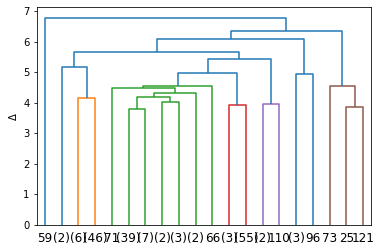

In [11]:
ax = plot1(Z)
ax.figure.savefig('plot1-test.png')
assert compare_images('plot1.png', 'plot1-test.png', tol=50) is None

We assign each point to a flat cluster using `fcluster`.

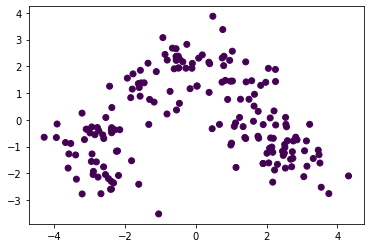

In [12]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=15, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 15**

Cluster the newsgroups dataset using Ward's method. What's the best value of $k$? Justify your answer.

We can cut at a distance of around 2.0 because this shows the biggest gap where there is no merging between that delta. If we cut along that line, we will end up with 3 clusters. Another possible cut is at a delta of 2.5, wherein we will end up with two clusters. At two clusters this seems to be a bit more balanced. If we look at the graph of the flat cluster at 2.0 and at 2.5, 2.5 seems to be a better candidate wherein there are two clusters that are balanced.

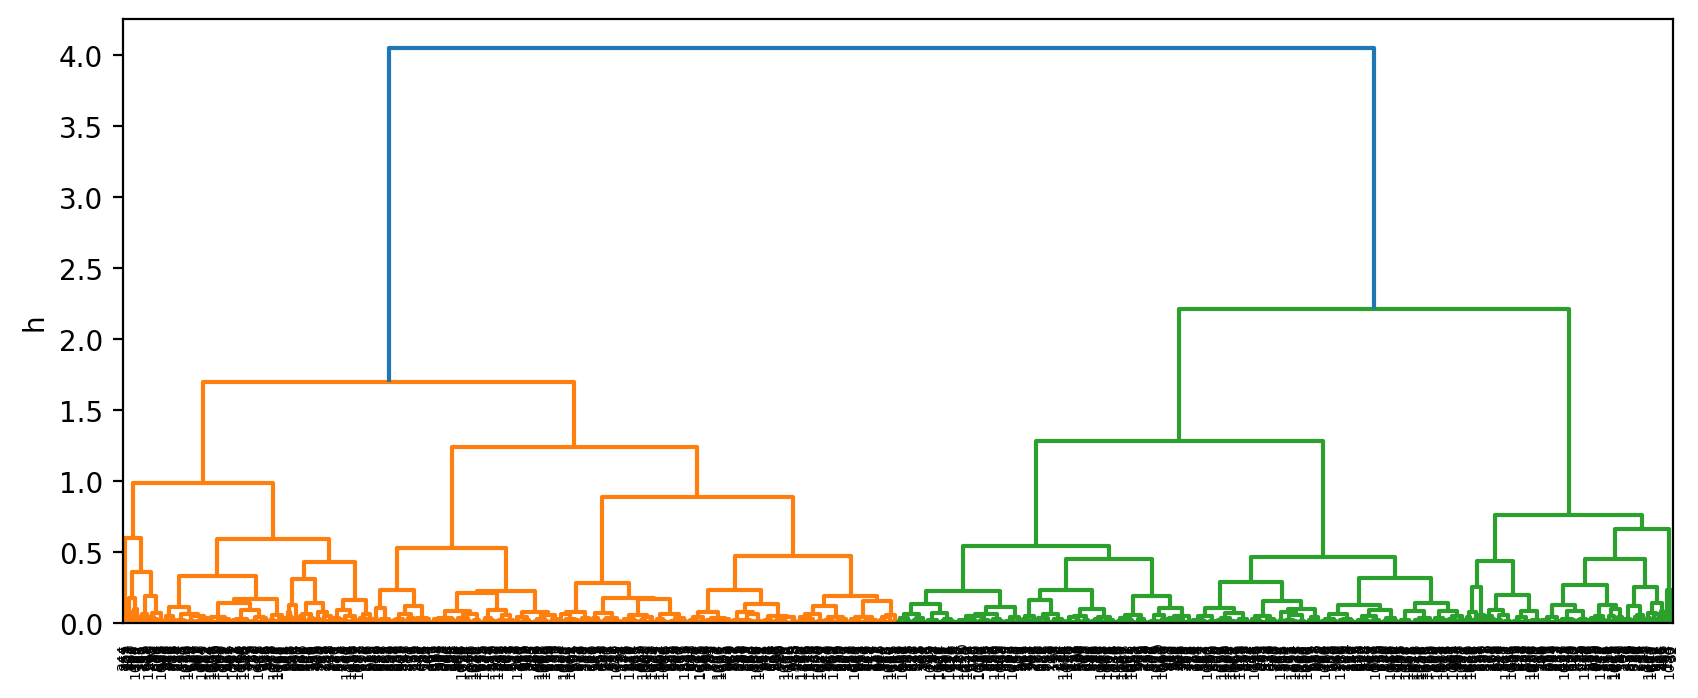

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel('h');

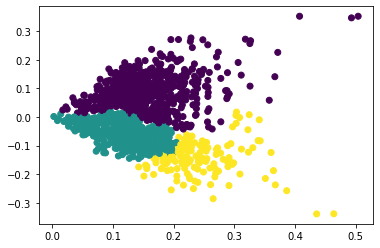

In [14]:
from scipy.cluster.hierarchy import fcluster
y_predict_ng = fcluster(Z, t=2.0, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

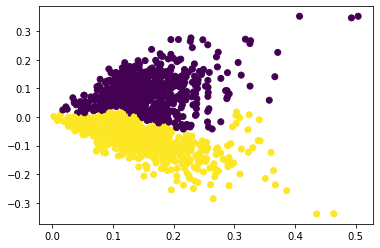

In [15]:
from scipy.cluster.hierarchy import fcluster
y_predict_ng = fcluster(Z, t=2.5, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

## Single linkage

Single linkage uses the smallest intercluster distance as the metric. Let's try it on the wines dataset.

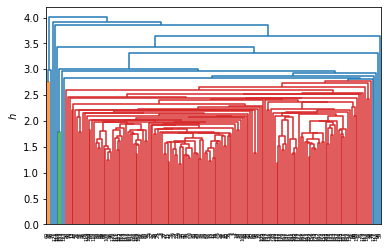

In [16]:
Z = linkage(X_wine, method='single', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

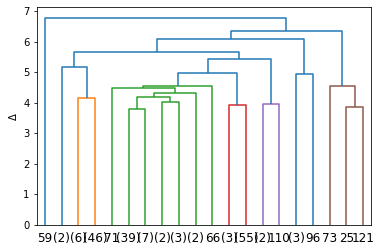

In [17]:
plot1(Z);

This will be the clustering if we set the threshold to 3.

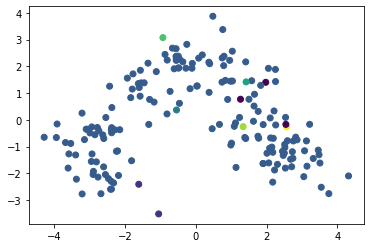

In [18]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=3, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 16**

Why is the clustering worse than with Ward's method?

There may be some points between two clusters that were taken/formed part of a single cluster. In single linkage there is breaching that can happen and this method is also susceptible to noise.

**Exercise 17**

Cluster the newsgroups dataset using single linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

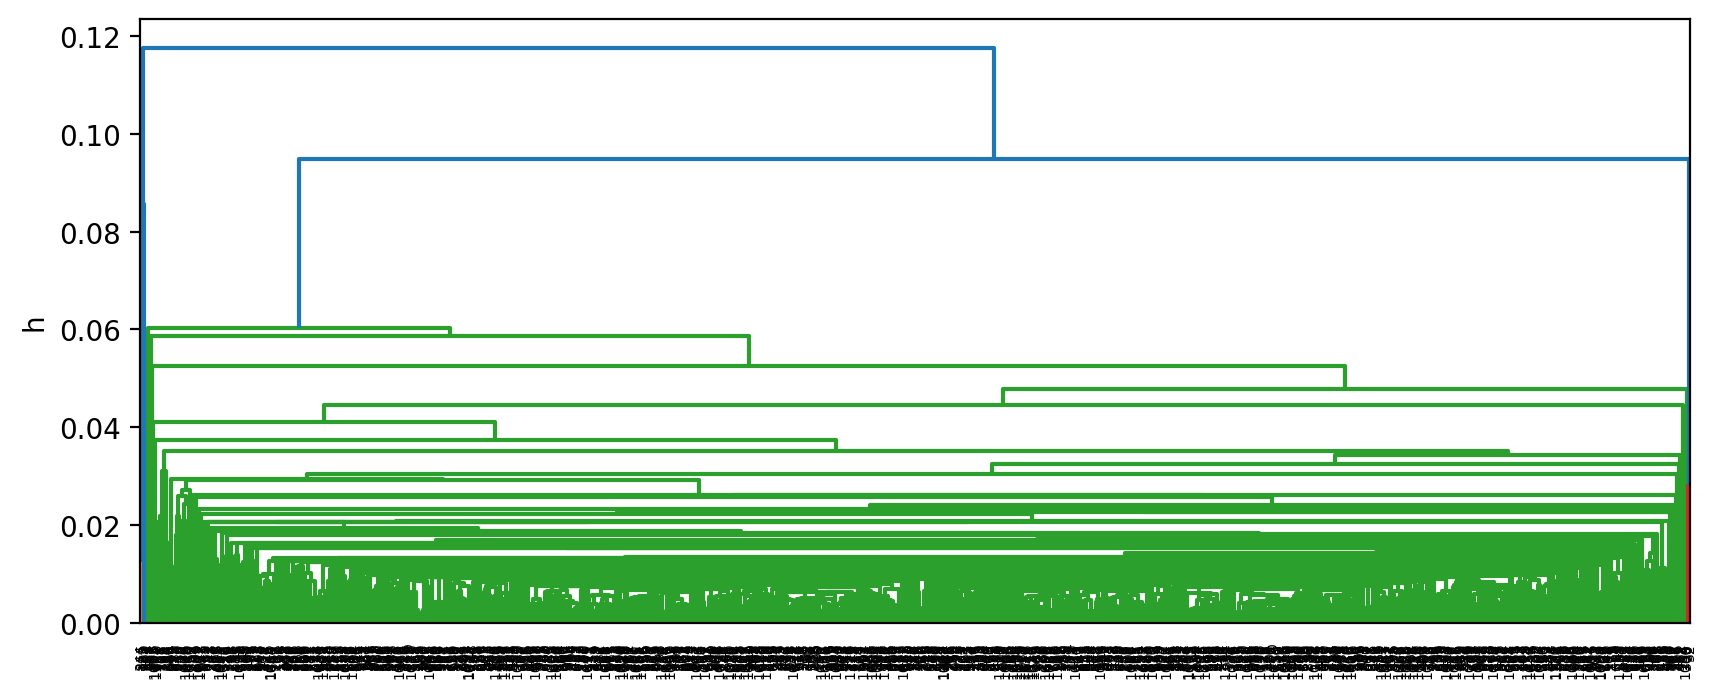

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_ng_new, method='single', optimal_ordering=True)
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel('h');

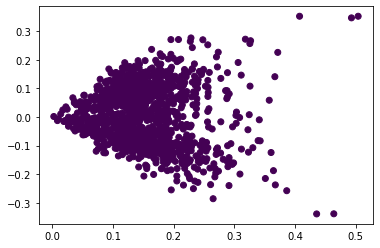

In [20]:
from scipy.cluster.hierarchy import fcluster
y_predict_ng = fcluster(Z, t=0.8, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

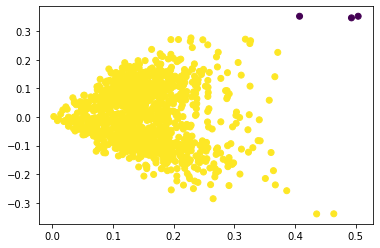

In [21]:
from scipy.cluster.hierarchy import fcluster
y_predict_ng = fcluster(Z, t=0.10, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

The candidate cut-off/threshold point is at 0.80 and 0.10 since these has the largest gap in the delta. Further analysis of the PCA plots show that there may indeed be just one cluster, or two clusters wherein the outliers are assigned to another cluster. 

## Complete linkage

Complete linkage uses the largest intercluster distance as the metric. Let's try it on the wines dataset.

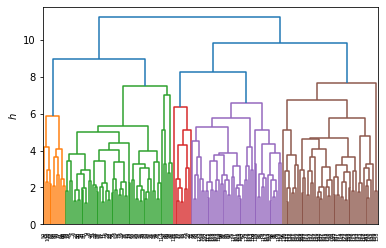

In [22]:
Z = linkage(X_wine, method='complete', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

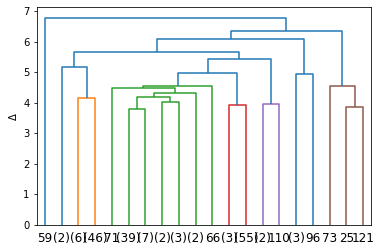

In [23]:
plot1(Z);

This will be the clustering if we set the threshold to 9.

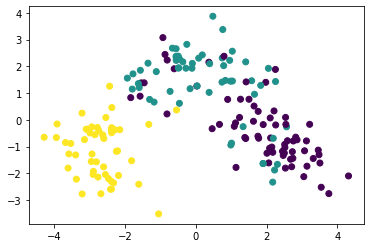

In [24]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=9, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 18**

Compare the clustering with those of Ward's method and single linkage. Is complete linkage better or worse than other methods?

Single linkage is the worst method so far because it is possible that some form of breaching can happen if there are points in between two clusters (i.e., this will form a single cluster). As can be seen from the wines dataset, the single linkage atthreshold=3 shows an imbalanced cluster. Meanwhile, Ward's method shows a more balanced cluster between threshold = 15 to 20. The complete linkage shows almost similar result to Wards, with a threshold between 8.5 to 9 showing 4 clusters that looks balanced. Between Ward's method and complete linkage, the clusters in Ward's method looks more balanced.

**Exercise 19**

Cluster the newsgroups dataset using complete linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

The threshold could be set at around 0.40 because this has the largest gap. This results to 4 clusters, and treated the outliers as their own clusters.

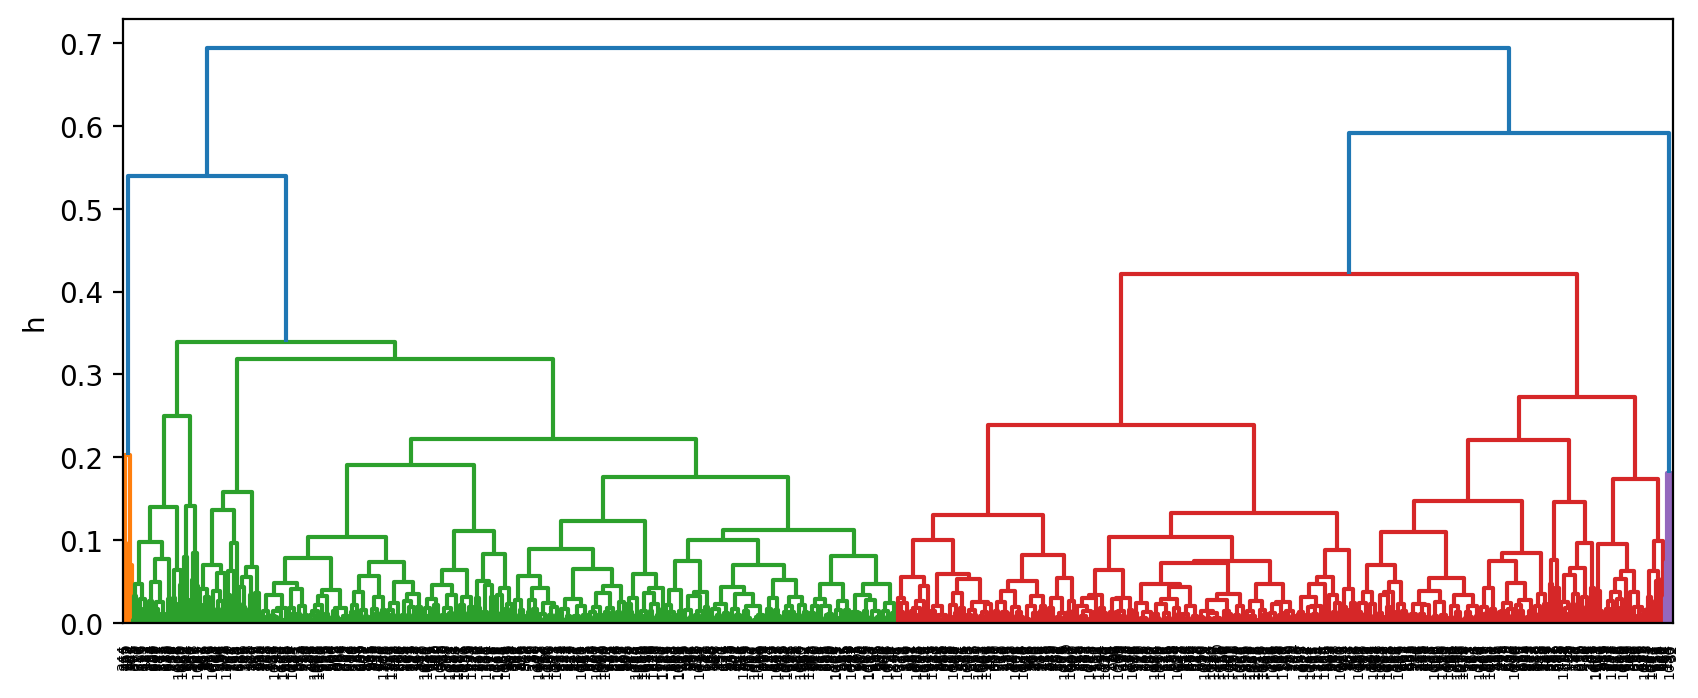

In [34]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_ng_new, method='complete', optimal_ordering=True)
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel('h');

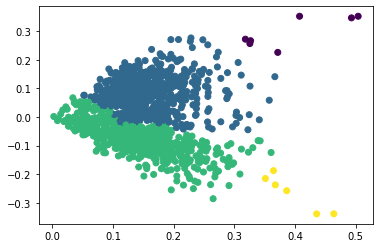

In [35]:
from scipy.cluster.hierarchy import fcluster
y_predict_ng = fcluster(Z, t=0.5, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

## Average linkage

Average linkage uses the average intercluster distance as the metric. Let's try it on the wines dataset.

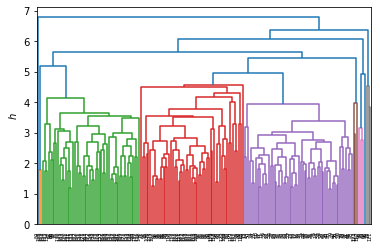

In [27]:
Z = linkage(X_wine, method='average', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, color_threshold=4.8, ax=ax)
ax.set_ylabel(r'$h$');

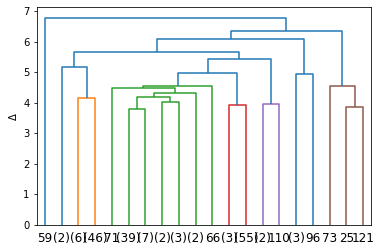

In [28]:
plot1(Z);

This will be the clustering if we set the threshold to 4.5.

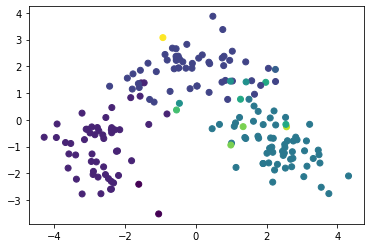

In [29]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=4.5, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 20**

Compare the clustering with those of Ward's method, single linkage and complete linkage. Is average linkage better or worse than other methods?

Average linkage seems to perform better than single linkage, producing a more balanced cluster. It seems comparable to Ward's method and complete linkage, wherein the cluster is almost balanced on the set thresholds.

**Exercise 21**

Cluster the newsgroups dataset using average linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

We evaluate the thresholds equal to about 0.2 and 0.30. At t=0.20 there are 4 clusters but this is imbalanced. If we raise the threshold to 0.30 we will end up with 3 clusters that still looks imbalanced.

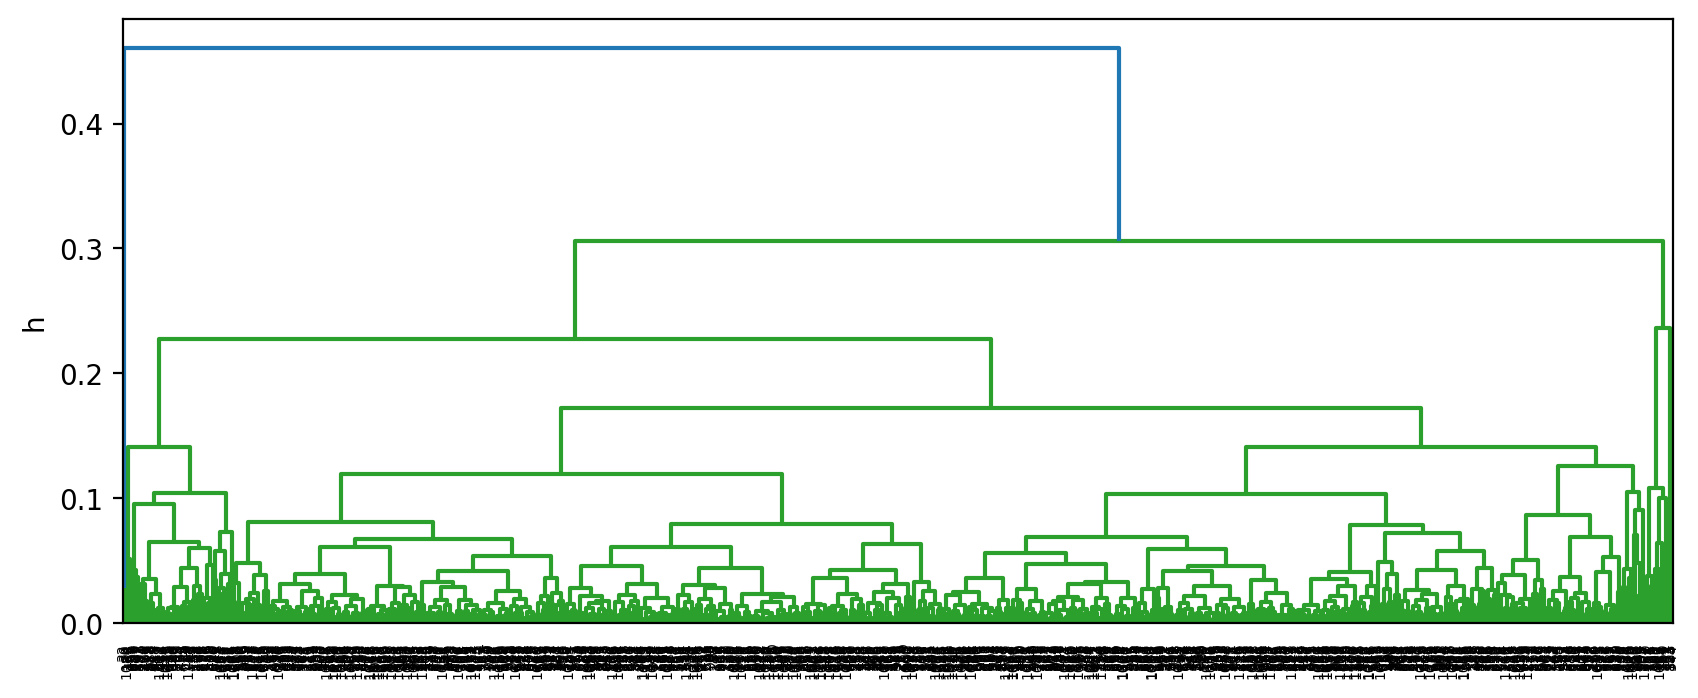

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_ng_new, method='average', optimal_ordering=True)
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel('h');

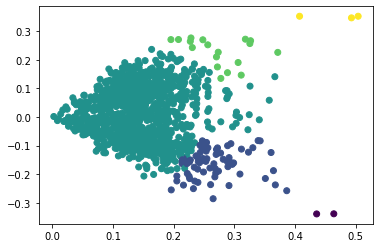

In [31]:
from scipy.cluster.hierarchy import fcluster
y_predict_ng = fcluster(Z, t=0.2, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

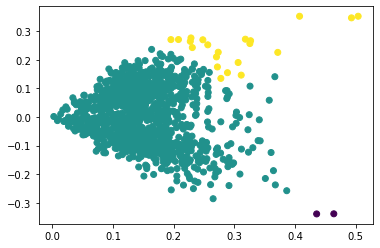

In [32]:
from scipy.cluster.hierarchy import fcluster
y_predict_ng = fcluster(Z, t=0.3, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

# References
* C. Shalizi, Statistics 36-350 lecture notes, http://www.stat.cmu.edu/~cshalizi/350/lectures/07/lecture-07.pdf
* C. Aggarwal, Data Mining: The Textbook, Chapter 6.